In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric import nn as gnn
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split

sns.set_style(style="whitegrid")

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from service import EnvironmentSecretService

In [5]:
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe


DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["AVAXUSDT", "TONUSDT", "1000PEPEUSDT", "LINKUSDT", "XRPUSDT", "SOLUSDT", "NEARUSDT"]
DEFAULT_TIMEFRAME = Timeframe.FIVE_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH
EPS = np.finfo(float).eps
DEVICE = 'cpu'
TODAY = datetime.now().strftime('%Y-%m-%d')

In [7]:
datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

In [8]:
symbols = ds.fetch_future_symbols()
symbols = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

In [9]:
raw_df_filename = f'remora_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{TODAY}.csv'

In [10]:
data = []
for symbol in symbols:
    try:
        for ohlcv in ds.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)
symbols_df.to_csv(raw_df_filename, index=False)

KeyboardInterrupt: 

In [11]:
symbols_df = pd.read_csv(raw_df_filename)

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [12]:
symbols_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume
0,1000PEPEUSDT,2024-03-25 00:25:00,0.007656,0.007665,0.007621,0.007642,146666400.0
1,1000PEPEUSDT,2024-03-25 00:30:00,0.007642,0.007672,0.007617,0.007620,129883200.0
2,1000PEPEUSDT,2024-03-25 00:35:00,0.007620,0.007631,0.007583,0.007590,425625312.0
3,1000PEPEUSDT,2024-03-25 00:40:00,0.007590,0.007639,0.007571,0.007638,154897792.0
4,1000PEPEUSDT,2024-03-25 00:45:00,0.007638,0.007662,0.007599,0.007601,130910600.0


In [13]:
def fe(df):
    df = df.copy()
    # label
    
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['sqr_log_return'] = df['log_return'] ** 2
    # features
    
    df['open2close'] = df['Open'] / df['Close']
    df['open2close_mean'] = df['open2close'].rolling(window=3).mean()
    df['open2close_std'] = df['open2close'].rolling(window=3).std()
    
    df['low2high'] = df['Low'] / df['High']
    df['low2high_mean'] = df['low2high'].rolling(window=3).mean()
    df['low2high_std'] = df['low2high'].rolling(window=3).std()
    
    df['hlcc4'] =  (df['High'] + df['Low'] + 2 * df['Close']) / 4.0
    df['hlcc4_std'] = df['hlcc4'].rolling(window=3).std()
    
    df['tr'] = np.maximum(
        df['High'] - df['Low'], 
        np.maximum(
            np.abs(df['High'] - df['Close'].shift(1)),
            np.abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['atr'] = df['tr'].rolling(window=3).mean()

    df['csize'] = df['High'] - df['Low']

    lcsize = df['csize'].max()

    df['nsize_1'] = df['csize'].shift(1) / lcsize
    df['nsize_2'] = df['csize'].shift(2) / lcsize
    df['nsize_3'] = df['csize'].shift(3) / lcsize

    df['rsize_2_1'] = df['nsize_2'] / df['nsize_1']
    df['rsize_3_1'] = df['nsize_3'] / df['nsize_1']
    df['rsize_3_2'] = df['nsize_3'] / df['nsize_2']

    df['gap_1_2'] = df['Open'].shift(1) - df['Close'].shift(1)
    df['gap_1_3'] = df['Open'].shift(2) - df['Close'].shift(1)
    df['gap_2_3'] = df['Open'].shift(2) - df['Close'].shift(2)

    df['rbody'] = (df['Close'] - df['Open']).abs()

    df['rbody_1_2'] = df['rbody'].shift(1) - df['rbody']
    df['rbody_1_3'] = df['rbody'].shift(2) - df['rbody']
    df['rbody_2_3'] = df['rbody'].shift(2) - df['rbody'].shift(1)

    df['slope_low_1_2'] = (df['Low'].shift(1) - df['Low']) / (df['Timestamp'].shift(1) - df['Timestamp']).dt.total_seconds()
    df['slope_high_1_2'] = (df['High'].shift(1) - df['High']) / (df['Timestamp'].shift(1) - df['Timestamp']).dt.total_seconds()
    df['slope_low_1_3'] = (df['Low'].shift(2) - df['Low']) / (df['Timestamp'].shift(2) - df['Timestamp']).dt.total_seconds()
    df['slope_high_1_3'] = (df['High'].shift(2) - df['High']) / (df['Timestamp'].shift(2) - df['Timestamp']).dt.total_seconds()

    max_real_body = df['rbody'].max()

    df['nrbody_1'] = df['rbody'] / max_real_body
    df['nrbody_2'] = df['rbody'].shift(1) / max_real_body
    df['nrbody_3'] = df['rbody'].shift(2) / max_real_body

    df['nrbody_1_total'] = df['rbody'] / df['csize']
    df['nrbody_2_total'] = df['rbody'].shift(1) / df['csize'].shift(1)
    df['nrbody_3_total'] = df['rbody'].shift(2) / df['csize'].shift(2)

    df.dropna(subset=['log_return', 'sqr_log_return', 'nsize_2', 'nsize_3'], inplace=True)

    return df

In [14]:
df_fe = fe(symbols_df)
features = [
    'open2close_mean', 'open2close_std',
    'low2high_mean', 'low2high_std',
    'atr', 'hlcc4_std',
    'nsize_1', 'nsize_2', 'nsize_3',
    'rsize_2_1', 'rsize_3_1', 'rsize_3_2',
    'gap_1_2', 'gap_1_3', 'gap_2_3',
    'rbody_1_2', 'rbody_1_3', 'rbody_2_3',
    'slope_low_1_2', 'slope_high_1_2', 'slope_low_1_3', 'slope_high_1_3',
    'nrbody_1', 'nrbody_2', 'nrbody_3',
    'nrbody_1_total', 'nrbody_2_total', 'nrbody_3_total',
]
label = 'sqr_log_return'

X = df_fe[features]
y = df_fe[label]

In [15]:
X.head()

,open2close_mean,open2close_std,low2high_mean,low2high_std,atr,hlcc4_std,nsize_1,nsize_2,nsize_3,rsize_2_1,...,slope_low_1_2,slope_high_1_2,slope_low_1_3,slope_high_1_3,nrbody_1,nrbody_2,nrbody_3,nrbody_1_total,nrbody_2_total,nrbody_3_total
3,1.000172,0.005650,0.992577,0.001357,0.000057,0.000017,0.000002,0.000003,0.000002,1.160338,...,-4.266699e-08,2.566725e-08,-7.683334e-08,-5.533298e-08,3.716242e-06,2.366974e-06,0.000002,0.709858,0.647670,0.385456
4,1.000872,0.006234,0.992260,0.001378,0.000059,0.000012,0.000003,0.000002,0.000003,0.698083,...,9.533328e-08,7.633275e-08,2.633315e-08,5.100000e-08,2.860424e-06,3.716242e-06,0.000002,0.596456,0.709858,0.647670
5,0.998022,0.006009,0.992438,0.001677,0.000058,0.000007,0.000003,0.000003,0.000002,1.091642,...,5.001202e-09,-5.766594e-08,5.016724e-08,9.333404e-09,2.652258e-06,2.860424e-06,0.000004,0.792620,0.596456,0.709858
6,1.000204,0.004693,0.993790,0.001706,0.000048,0.000010,0.000002,0.000003,0.000003,1.433182,...,5.399964e-08,3.266614e-08,2.950042e-08,-1.249990e-08,1.387649e-07,2.652258e-06,0.000003,0.048643,0.792620,0.596456
7,0.996373,0.003507,0.992930,0.003170,0.000054,0.000024,0.000002,0.000002,0.000003,1.172974,...,1.200009e-08,1.633338e-07,3.299986e-08,9.799997e-08,3.916724e-06,1.387649e-07,0.000003,0.616503,0.048643,0.792620


In [16]:
y.head()

3    4.007594e-05
4    2.370850e-05
5    2.039037e-05
6    5.558474e-08
7    4.399577e-05
Name: sqr_log_return, dtype: float32

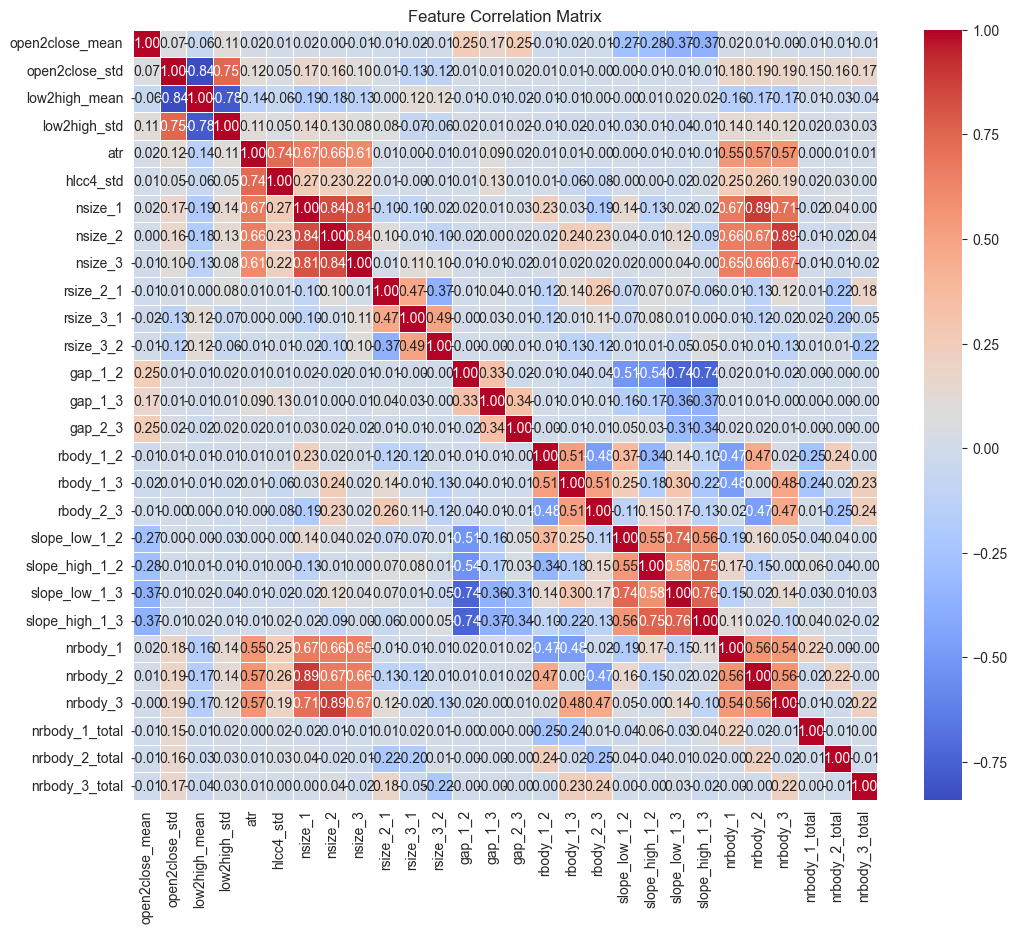

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=seed)

scaler = StandardScaler()
rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)

kf = StratifiedKFold(n_splits=5, shuffle=False, random_state=seed)

fold_mse = []
fold_r2 = []
calibrators = []

for train_index, test_index in kf.split(X_train):
    X_tr, X_tst = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_tst = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_tst)
    
    rf_model.fit(X_train_scaled, y_tr)
    
    y_pred_raw = rf_model.predict(X_test_scaled)
    
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(y_pred_raw, y_tst)
    calibrators.append(iso_reg)
    
    y_pred_calibrated = iso_reg.predict(y_pred_raw)

    mse = mean_squared_error(y_tst, y_pred_calibrated)
    r2 = r2_score(y_tst, y_pred_calibrated)

    fold_mse.append(mse)
    fold_r2.append(r2)
    
    print(f"Fold MSE: {mse:.6f}, Fold R2: {r2:.4f}")

print(f"\nAverage MSE across folds: {np.mean(fold_mse):.6f}")
print(f"Average R2 across folds: {np.mean(fold_r2):.4f}")


ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [240]:
rf_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
})

rf_imp = rf_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)

rf_imp.head(10)

,feature,importance
0,hlcc4_std,0.477342
1,gap_2_3,0.060459
2,atr,0.058609
3,nrbody_3_total,0.045003
4,nrbody_2,0.038455
5,low2high_std,0.037024
6,open2close_mean,0.034235
7,nsize_1,0.029136
8,gap_1_3,0.021858
9,gap_1_2,0.021727


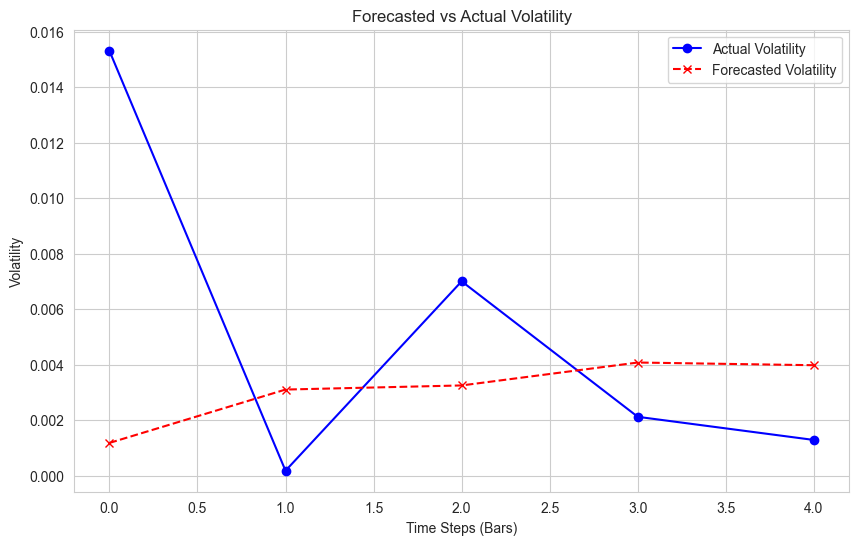

Mean Squared Error (MSE) for Volatility: 0.000047
R-squared (R2) for Volatility: -0.501093


In [241]:
forecast_steps = 5

last_data_point = X_test.iloc[-1].values.reshape(1, -1)
final_calibrator = calibrators[-1]

forecasted_squared_volatility = []
forecasted_intervals = []

non_conformity_scores = []

for i in range(forecast_steps):
    forecast_raw = rf_model.predict(last_data_point)
    forecast = final_calibrator.predict(forecast_raw)
    
    forecasted_squared_volatility.append(forecast[0])
    
    last_data_point = np.roll(last_data_point, shift=-1, axis=1)
    last_data_point[0, -1] = forecast[0]

forecasted_volatility = np.sqrt(forecasted_squared_volatility)
actual_squared_volatility = y_test.iloc[-forecast_steps:].values
actual_volatility = np.sqrt(actual_squared_volatility)

plt.figure(figsize=(10, 6))

plt.plot(range(forecast_steps), actual_volatility, label='Actual Volatility', color='blue', marker='o')
plt.plot(range(forecast_steps), forecasted_volatility, label='Forecasted Volatility', color='red', linestyle='--', marker='x')

plt.title('Forecasted vs Actual Volatility')
plt.xlabel('Time Steps (Bars)')
plt.ylabel('Volatility')
plt.legend()

plt.show()

mse_volatility = mean_squared_error(actual_volatility, forecasted_volatility)
r2_volatility = r2_score(actual_volatility, forecasted_volatility)

print(f'Mean Squared Error (MSE) for Volatility: {mse_volatility:.6f}')
print(f'R-squared (R2) for Volatility: {r2_volatility:.6f}')


In [19]:
window_size = 14
patches = []

for start in range(0, len(df_fe) - window_size + 1, window_size):
    end = start + window_size
    patch = df_fe.iloc[start:end]
    patches.append(patch)

In [20]:
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.data import Data

graph = []
batch_size = 8
threshold = 0.5

for i in range(0, len(patches), batch_size):
    batch_patches = patches[i:i + batch_size]

    for patch in batch_patches:
        X_patch = patch[features]
        y_patch = patch[label]

        scaler = MinMaxScaler()
        X_patch_scaled = scaler.fit_transform(X_patch)

        corr_matrix = pd.DataFrame(X_patch_scaled).corr()

        edges = []
        for idx1 in range(X_patch_scaled.shape[1]):
            for idx2 in range(X_patch_scaled.shape[1]):
                if idx1 != idx2 and abs(corr_matrix.iloc[idx1, idx2]) > threshold:
                    edges.append((idx1, idx2))

        x = torch.tensor(X_patch_scaled, dtype=torch.float)
        
        edges = [(i, j) for i, j in edges if i < x.size(0) and j < x.size(0)]
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        y_q25 = torch.tensor([y_patch.quantile(0.25)], dtype=torch.float)
        y_q75 = torch.tensor([y_patch.quantile(0.75)], dtype=torch.float)

        graph.append(Data(x=x, edge_index=edge_index, y_q25=y_q25, y_q75=y_q75))



In [21]:
from torch_geometric.loader import DataLoader

train_graphs, test_graphs = train_test_split(graph, test_size=0.2, shuffle=True, random_state=seed)

train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

In [22]:
next(iter(train_loader))

DataBatch(x=[14, 28], edge_index=[2, 26], y_q25=[1], y_q75=[1], batch=[14], ptr=[2])

In [30]:
class GVAG(nn.Module):
    def __init__(self, in_channels, hidden_dim, latent_dim, num_heads=4, gru_hidden_dim=64, dropout=0.2, gru_layers=2):
        super(GVAG, self).__init__()
        self.gat1 = gnn.GATConv(in_channels, hidden_dim, heads=num_heads, dropout=dropout)
        self.gat2 = gnn.GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout)

        self.pooling = gnn.SAGPooling(hidden_dim, ratio=0.8)
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.gru = nn.GRU(latent_dim, gru_hidden_dim, num_layers=gru_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
        self.fc_out_q25 = nn.Linear(gru_hidden_dim * 2, 1)
        self.fc_out_q75 = nn.Linear(gru_hidden_dim * 2, 1)
        
        self.activation = nn.SELU()

    def encode(self, x, edge_index, batch):
        x = self.activation(self.gat1(x, edge_index))
        x = self.activation(self.gat2(x, edge_index))
        
        x, edge_index, _, batch, perm, _ = self.pooling(x, edge_index, batch=batch)
        x = gnn.global_mean_pool(x, batch)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar, x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        return mu + eps * std

    def decode(self, z):
        gru_out, _ = self.gru(z.unsqueeze(1))
        return gru_out

    def forward(self, x, edge_index, batch):
        mu, logvar, pooled_x = self.encode(x, edge_index, batch)
        z = self.reparameterize(mu, logvar)
        
        gru_out = self.decode(z)
        
        q25_pred = self.fc_out_q25(gru_out[:, -1, :])
        q75_pred = self.fc_out_q75(gru_out[:, -1, :])
        
        return q25_pred, q75_pred, mu, logvar


In [31]:
def quant_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    loss = torch.max(quantile * error, (quantile - 1) * error)

    return loss.mean()

def combo_loss(y_true_q25, y_true_q75, q25_pred, q75_pred, mu, logvar):
    loss_q25 = quant_loss(y_true_q25, q25_pred, 0.25)
    loss_q75 = quant_loss(y_true_q75, q75_pred, 0.75)
    
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / mu.size(0)

    total_loss = loss_q25 + loss_q75 + kl_loss
    return total_loss


In [32]:
from notebooks.train import CheckPoint, EarlyStop, SnapshotManager

n_snapshots = 3
patience = 16
snapshot_interval = 5
epoch = 20

INPUT = len(features)
HIDDEN = 64
LATENT = 16
LR = 0.0001

model_gvag = GVAG(in_channels=INPUT, hidden_dim=HIDDEN, latent_dim=LATENT)
optimizer = torch.optim.Adam(model_gvag.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
criterion = None

snapshot_manager = SnapshotManager(model_gvag, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=patience)
checkpoint = CheckPoint(
    snapshot_manager=snapshot_manager, snapshot_interval=snapshot_interval
)

In [39]:
from notebooks.train import Trainer


class GVAGTrainer(Trainer):
    def __init__(self, *args, acc_steps=4, **kwargs):
        super().__init__(*args, **kwargs)
        self.acc_steps = acc_steps

    def train_epoch(self):
        self.model.train()
        running_train_loss = 0.0
        num_batches = len(self.train_dataloader)
        acc_loss = 0.0

        for batch_idx, batch in enumerate(self.train_dataloader):
            x = batch[0].x.to(DEVICE)
            edge_index = batch[0].edge_index.to(DEVICE)
            b = None
            y_q25 = batch[0].y_q25.to(DEVICE)
            y_q75 = batch[0].y_q75.to(DEVICE)

            q25_pred, q75_pred, mu, logvar = self.model(x=x, edge_index=edge_index, batch=b)
        
            loss = combo_loss(
                y_true_q25=y_q25,
                y_true_q75=y_q75, 
                q25_pred=q25_pred, 
                q75_pred=q75_pred,
                mu=mu, 
                logvar=logvar
            )
            acc_loss += loss.item()

            loss.backward()

            if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                self.optimizer.step()
                self.optimizer.zero_grad()
                running_train_loss += acc_loss
                acc_loss = 0.0

        avg_train_loss = running_train_loss / max(1, (num_batches + self.acc_steps - 1) // self.acc_steps)

        return avg_train_loss

    def valid_epoch(self):
        return 0.0

In [40]:
trainer = GVAGTrainer(
    model_gvag,
    train_loader,
    test_loader,
    optimizer,
    scheduler,
    criterion,
    early_stop,
    checkpoint,
    device=DEVICE
)

No snapshots found, starting from scratch.


In [41]:
trainer.train(epoch)

Start training with epochs 20
Epoch 1/20, Train_Loss: 0.0223, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GVAG_epoch_1_improved.pth
Epoch 2/20, Train_Loss: 0.0028, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GVAG_epoch_2_improved.pth
Epoch 3/20, Train_Loss: 0.0013, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GVAG_epoch_3_improved.pth
Epoch 4/20, Train_Loss: 0.0005, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GVAG_epoch_4_improved.pth
Removed old improved snapshot: snapshots/GVAG_epoch_1_improved.pth
Removed old improved snapshot: snapshots/GVAG_epoch_2_improved.pth
Removed old improved snapshot: snapshots/GVAG_epoch_3_improved.pth
Epoch 5/20, Train_Loss: 0.0003, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GVAG_epoch_5_improved.pth
Saved periodic snapshot: snapshots/GVAG_epoch_5_periodic.pth
Epoch 6/20, Train_Loss: 0.0003, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GVAG_epoch_6_improved.pth
Removed old improved snapshot: snapshots/GVAG_ep

KeyboardInterrupt: 

In [42]:
model_gvag_inf = GVAG(in_channels=INPUT, hidden_dim=HIDDEN, latent_dim=LATENT)
model_gvag_inf.to(DEVICE)

snapshot_manager = SnapshotManager(model_gvag_inf)
snapshot_manager.load_latest()

Loaded snapshot: snapshots/GVAG_epoch_10_improved.pth


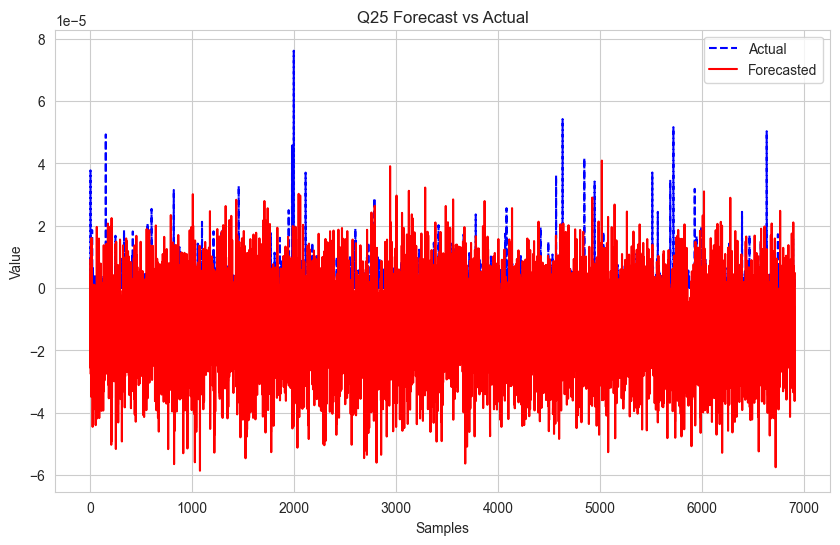

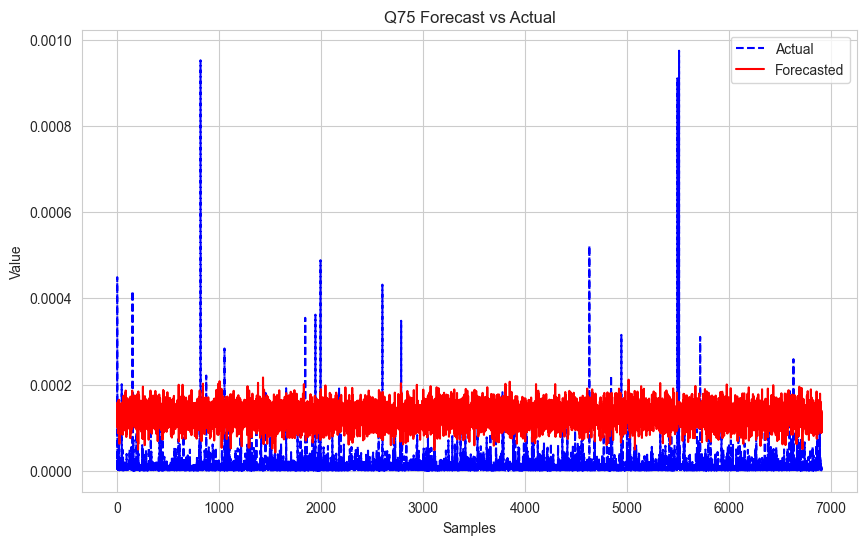

In [44]:
def test_forecast(model, test_loader, device=DEVICE):
    model.eval()
    
    actual_q25 = []
    actual_q75 = []
    forecasted_q25 = []
    forecasted_q75 = []

    with torch.no_grad():
        for batch in test_loader:
            x = batch[0].x.to(device)
            edge_index = batch[0].edge_index.to(device)
            b = None
            y_q25 = batch[0].y_q25.to(device)
            y_q75 = batch[0].y_q75.to(device)

            q25_pred, q75_pred, mu, logvar = model(x=x, edge_index=edge_index, batch=b)

            actual_q25.append(y_q25.cpu().numpy())
            actual_q75.append(y_q75.cpu().numpy())
            forecasted_q25.append(q25_pred.cpu().numpy())
            forecasted_q75.append(q75_pred.cpu().numpy())

    actual_q25 = np.concatenate(actual_q25, axis=0)
    actual_q75 = np.concatenate(actual_q75, axis=0)
    forecasted_q25 = np.concatenate(forecasted_q25, axis=0)
    forecasted_q75 = np.concatenate(forecasted_q75, axis=0)

    plot_forecast(actual_q25, forecasted_q25, title="Q25 Forecast vs Actual")
    plot_forecast(actual_q75, forecasted_q75, title="Q75 Forecast vs Actual")


def plot_forecast(actual, forecasted, title="Forecast vs Actual"):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label="Actual", color="blue", linestyle='dashed')
    plt.plot(forecasted, label="Forecasted", color="red", linestyle='solid')
    plt.xlabel("Samples")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


test_forecast(model_gvag_inf, test_loader, DEVICE)